<a href="https://colab.research.google.com/github/Avelez164/Machine-Learning/blob/main/lab_gene_partial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab:  Logistic Regression for Gene Expression Data

In this lab, we use logistic regression to predict biological characteristics ("phenotypes") from gene expression data.  In addition to the concepts in [breast cancer demo](./breast_cancer.ipynb), you will learn to:
* Handle missing data
* Perform multi-class logistic classification
* Create a confusion matrix
* Use L1-regularization for improved estimation in the case of sparse weights (Grad students only)

## Background

Genes are the basic unit in the DNA and encode blueprints for proteins.  When proteins are synthesized from a gene, the gene is said to "express".  Micro-arrays are devices that measure the expression levels of large numbers of genes in parallel.  By finding correlations between expression levels and phenotypes, scientists can identify possible genetic markers for biological characteristics.

The data in this lab comes from:

https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression

In this data, mice were characterized by three properties:
* Whether they had down's syndrome (trisomy) or not
* Whether they were stimulated to learn or not
* Whether they had a drug memantine or a saline control solution.

With these three choices, there are 8 possible classes for each mouse.  For each mouse, the expression levels were measured across 77 genes.  We will see if the characteristics can be predicted from the gene expression levels.  This classification could reveal which genes are potentially involved in Down's syndrome and if drugs and learning have any noticeable effects.


## Load the Data

We begin by loading the standard modules.

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing


Use the `pd.read_excel` command to read the data from

https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls

into a dataframe `df`.  Use the `index_col` option to specify that column 0 is the index.  Use the `df.head()` to print the first few rows.

In [3]:
# TODO
# TODO
#   df = pd.read_excel(...)

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls"
df = pd.read_excel(url, index_col=0)
df.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


# This data has missing values.  The site:

http://pandas.pydata.org/pandas-docs/stable/missing_data.html

has an excellent summary of methods to deal with missing values.  Following the techniques there, create a new data frame `df1` where the missing values in each column are filled with the mean values from the non-missing values.

In [4]:
# TODO
#  df1 = ...

df1 = df.fillna(df.mean(numeric_only=True))
print(df1.head())


         DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N   pBRAF_N  \
MouseID                                                                         
309_1    0.503644  0.747193  0.430175  2.816329  5.990152  0.218830  0.177565   
309_2    0.514617  0.689064  0.411770  2.789514  5.685038  0.211636  0.172817   
309_3    0.509183  0.730247  0.418309  2.687201  5.622059  0.209011  0.175722   
309_4    0.442107  0.617076  0.358626  2.466947  4.979503  0.222886  0.176463   
309_5    0.434940  0.617430  0.358802  2.365785  4.718679  0.213106  0.173627   

         pCAMKII_N   pCREB_N    pELK_N  ...   pCFOS_N     SYP_N  H3AcK18_N  \
MouseID                                 ...                                  
309_1     2.373744  0.232224  1.750936  ...  0.108336  0.427099   0.114783   
309_2     2.292150  0.226972  1.596377  ...  0.104315  0.441581   0.111974   
309_3     2.283337  0.230247  1.561316  ...  0.106219  0.435777   0.111883   
309_4     2.152301  0.207004  1.595086  ..

## Binary Classification for Down's Syndrome

We will first predict the binary class label in `df1['Genotype']` which indicates if the mouse has Down's syndrome or not.  Get the string values in `df1['Genotype'].values` and convert this to a numeric vector `y` with 0 or 1.  You may wish to use the `np.unique` command with the `return_inverse=True` option.

In [5]:
# TODO
#   y = ...
y = df1['Genotype'].values
print(np.unique(y, return_inverse=True))

(array(['Control', 'Ts65Dn'], dtype=object), array([0, 0, 0, ..., 1, 1, 1]))


In [6]:
genotype_values = df1['Genotype'].values
unique_labels, y_numeric = np.unique(genotype_values, return_inverse=True)

# this assign the numeric vector to y
y = y_numeric

# prints the unique labels and the numeric vector for verification
print("Unique genotype labels:", unique_labels)
print("Numeric label vector (y):", y)


Unique genotype labels: ['Control' 'Ts65Dn']
Numeric label vector (y): [0 0 0 ... 1 1 1]


As predictors, get all but the last four columns of the dataframes.  Store the data matrix into `X` and the names of the columns in `xnames`.

In [9]:
# TODO
#   xnames = ...
#   X = ...
xnames = df1.columns[:-4]

# Extract the data matrix for these predictors
X = df1[xnames]

# Optional: Display the predictor column names and the first few rows of X
print("Predictor column names:", xnames.tolist())
print(X.head())



Predictor column names: ['DYRK1A_N', 'ITSN1_N', 'BDNF_N', 'NR1_N', 'NR2A_N', 'pAKT_N', 'pBRAF_N', 'pCAMKII_N', 'pCREB_N', 'pELK_N', 'pERK_N', 'pJNK_N', 'PKCA_N', 'pMEK_N', 'pNR1_N', 'pNR2A_N', 'pNR2B_N', 'pPKCAB_N', 'pRSK_N', 'AKT_N', 'BRAF_N', 'CAMKII_N', 'CREB_N', 'ELK_N', 'ERK_N', 'GSK3B_N', 'JNK_N', 'MEK_N', 'TRKA_N', 'RSK_N', 'APP_N', 'Bcatenin_N', 'SOD1_N', 'MTOR_N', 'P38_N', 'pMTOR_N', 'DSCR1_N', 'AMPKA_N', 'NR2B_N', 'pNUMB_N', 'RAPTOR_N', 'TIAM1_N', 'pP70S6_N', 'NUMB_N', 'P70S6_N', 'pGSK3B_N', 'pPKCG_N', 'CDK5_N', 'S6_N', 'ADARB1_N', 'AcetylH3K9_N', 'RRP1_N', 'BAX_N', 'ARC_N', 'ERBB4_N', 'nNOS_N', 'Tau_N', 'GFAP_N', 'GluR3_N', 'GluR4_N', 'IL1B_N', 'P3525_N', 'pCASP9_N', 'PSD95_N', 'SNCA_N', 'Ubiquitin_N', 'pGSK3B_Tyr216_N', 'SHH_N', 'BAD_N', 'BCL2_N', 'pS6_N', 'pCFOS_N', 'SYP_N', 'H3AcK18_N', 'EGR1_N', 'H3MeK4_N', 'CaNA_N']
         DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N   pBRAF_N  \
MouseID                                                                    

Split the data into training and test with 30% allocated for test.  You can use the train

In [19]:
from sklearn.model_selection import train_test_split

# TODO:
#   Xtr, Xts, ytr, yts = ...
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.3, random_state=42)

Scale the data with the `StandardScaler`.  Store the scaled values in `Xtr1` and `Xts1`.

In [18]:
from sklearn.preprocessing import StandardScaler

# TODO
#  Xtr1 = ...
#  Xts1 = ...
scaler = StandardScaler()
Xtr1 = scaler.fit_transform(Xtr)
Xts1 = scaler.transform(Xts)

Create a `LogisticRegression` object `logreg` and `fit` on the scaled training data.  Set the regularization level to `C=1e5` and use the optimizer `solver=liblinear`.

In [23]:
# TODO
#   logreg = ...
#   logreg.fit(...)
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e5, solver='liblinear')
logreg.fit(Xtr1, ytr)

LogisticRegression(C=100000.0, solver='liblinear')

Measure the accuracy of the classifer on test data.  You should get around 94%.  

In [29]:
# TODO
#   yhat = ...
yhat = logreg.predict(Xts1)
accuracy = np.mean(yhat == yts)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 96.60%


## Interpreting the weight vector

Create a stem plot of the coefficients, `W` in the logistic regression model.  Jse the `plt.stem()` function with the `use_line_collection=True` option.  You can get the coefficients from `logreg.coef_`, but you will need to reshape this to a 1D array.  

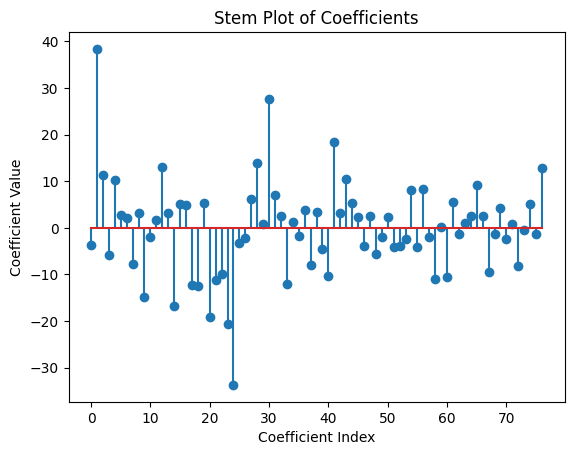

In [32]:
# TODO
#   W = ...
#   plt.stem(...)
W = logreg.coef_.reshape(-1)
plt.stem(W)
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.title('Stem Plot of Coefficients')
plt.show()

You should see that `W[i]` is very large for a few components `i`.  These are the genes that are likely to be most involved in Down's Syndrome.   Below we will use L1 regression to enforce sparsity.  Find the names of the genes for two components `i` where the magnitude of `W[i]` is largest.  

In [34]:
# TODO
top_two_indices = np.argsort(np.abs(W))[-2:]

print("Top two genes likely to be most involved in Down's Syndrome:")
for idx in top_two_indices:
    print(f"Gene: {xnames[idx]}, Coefficient: {W[idx]}")


Top two genes likely to be most involved in Down's Syndrome:
Gene: ERK_N, Coefficient: -33.698723197143885
Gene: ITSN1_N, Coefficient: 38.39831277631825


## Cross Validation

To obtain a slightly more accurate result, now perform 10-fold cross validation and measure the average precision, recall and f1-score.  Note, that in performing the cross-validation, you will want to randomly permute the test and training sets using the `shuffle` option.  In this data set, all the samples from each class are bunched together, so shuffling is essential.  Print the mean precision, recall and f1-score and error rate across all the folds.

In [36]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)

# TODO
precision_list = []
recall_list = []
f1_list = []
error_rate_list = []

# iterates over each fold
for train_index, test_index in kf.split(X):
    # selects training & testing data
    X_train = X.iloc[train_index]
    X_test  = X.iloc[test_index]
    y_train = y[train_index]
    y_test  = y[test_index]

    # initializes the model
    model = LogisticRegression(max_iter=1000)

    # Ttrains the model on the training set
    model.fit(X_train, y_train)

    # predict the test set
    y_pred = model.predict(X_test)

    # computes precision, recall
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

    # computes the error rate
    error_rate = np.mean(y_pred != y_test)

    # stores results of this fold
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    error_rate_list.append(error_rate)

# prints the mean metrics across all folds
print(f"Mean Precision: {np.mean(precision_list):.3f}")
print(f"Mean Recall: {np.mean(recall_list):.3f}")
print(f"Mean F1-Score: {np.mean(f1_list):.3f}")
print(f"Mean Error Rate: {np.mean(error_rate_list):.3f}")


Mean Precision: 0.919
Mean Recall: 0.912
Mean F1-Score: 0.915
Mean Error Rate: 0.080


## Multi-Class Classification

Now use the response variable in `df1['class']`.  This has 8 possible classes.  Use the `np.unique` funtion as before to convert this to a vector `y` with values 0 to 7.

In [43]:
# TODO
#   y = ...
unique_classes, y_numeric = np.unique(df1['class'].values, return_inverse=True)
y = y_numeric

print("Unique class labels:", unique_classes)
print("Numeric vector y:", y)


Unique class labels: ['c-CS-m' 'c-CS-s' 'c-SC-m' 'c-SC-s' 't-CS-m' 't-CS-s' 't-SC-m' 't-SC-s']
Numeric vector y: [0 0 0 ... 7 7 7]


Fit a multi-class logistic model by creating a `LogisticRegression` object, `logreg` and then calling the `logreg.fit` method.

Now perform 10-fold cross validation, and measure the confusion matrix `C` on the test data in each fold. You can use the `confustion_matrix` method in the `sklearn` package.  Add the confusion matrix counts across all folds and then normalize the rows of the confusion matrix so that they sum to one.  Thus, each element `C[i,j]` will represent the fraction of samples where `yhat==j` given `ytrue==i`.  Print the confusion matrix.  You can use the command

    print(np.array_str(C, precision=4, suppress_small=True))
    
to create a nicely formatted print.  Also print the overall mean and SE of the test accuracy across the folds.

In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

# TODO
nfold = 10
kf = KFold(n_splits=nfold, shuffle=True, random_state=42)
n_classes = len(unique_classes)  # Should be 8 for this data

# Initialize an accumulator for the confusion matrix
C_total = np.zeros((n_classes, n_classes), dtype=float)
accuracy_list = []

# Loop over the folds
for train_index, test_index in kf.split(X):
    # Use .iloc for DataFrame slicing; note that y is now numeric!
    X_train = X.iloc[train_index]
    X_test  = X.iloc[test_index]
    y_train = y[train_index]
    y_test  = y[test_index]

    # Initialize and fit the logistic regression model.
    # (The warning about 'multi_class' is issued because its default behavior will change.
    # For now, you can leave it to default or specify multi_class='multinomial', as shown.)
    logreg = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
    logreg.fit(X_train, y_train)

    # Predict labels for the test set
    y_pred = logreg.predict(X_test)

    # Compute confusion matrix for this fold and accumulate counts
    fold_confusion = confusion_matrix(y_test, y_pred, labels=np.arange(n_classes))
    C_total += fold_confusion

    # Compute and store the accuracy for this fold
    fold_accuracy = np.mean(y_pred == y_test)
    accuracy_list.append(fold_accuracy)

# Normalize the cumulative confusion matrix so that each row sums to one.
C_normalized = np.zeros_like(C_total)
for i in range(n_classes):
    row_sum = np.sum(C_total[i, :])
    if row_sum > 0:
        C_normalized[i, :] = C_total[i, :] / row_sum

# Print the normalized confusion matrix
print("\nNormalized Confusion Matrix (rows sum to 1):")
print(np.array_str(C_normalized, precision=4, suppress_small=True))

# Calculate and print overall mean accuracy and standard error (SE)
mean_accuracy = np.mean(accuracy_list)
se_accuracy = np.std(accuracy_list, ddof=1) / np.sqrt(nfold)
print(f"\nMean Test Accuracy: {mean_accuracy:.4f}")
print(f"Standard Error (SE) of Test Accuracy: {se_accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi


Normalized Confusion Matrix (rows sum to 1):
[[0.7933 0.1533 0.     0.     0.0533 0.     0.     0.    ]
 [0.1037 0.7778 0.     0.     0.0815 0.037  0.     0.    ]
 [0.     0.     1.     0.     0.     0.     0.     0.    ]
 [0.     0.0074 0.     0.9481 0.     0.     0.     0.0444]
 [0.0074 0.0741 0.     0.     0.8741 0.0222 0.     0.0222]
 [0.     0.0476 0.     0.     0.019  0.9333 0.     0.    ]
 [0.     0.     0.0963 0.0148 0.     0.     0.8889 0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.    ]]

Mean Test Accuracy: 0.9009
Standard Error (SE) of Test Accuracy: 0.0116


Re-run the logistic regression on the entire training data and get the weight coefficients.  This should be a 8 x 77 matrix.  Create a stem plot of the first row of this matrix to see the coefficients on each of the genes.


Shape of the weight matrix: (8, 77)


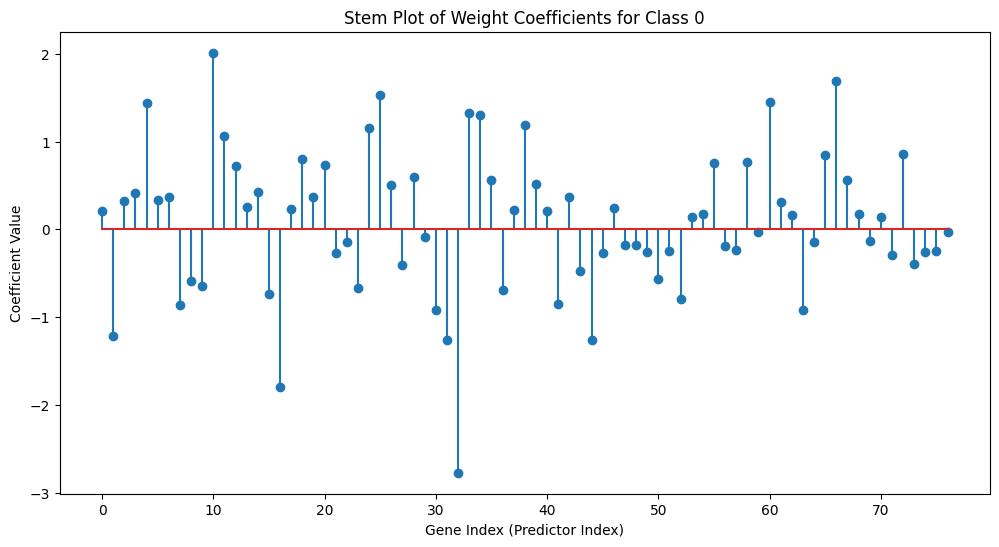


Top two genes in Class 0 based on absolute weight:
Gene: pERK_N, Coefficient: 2.011511310445676
Gene: SOD1_N, Coefficient: -2.7731059302925396


In [48]:
# TODO
logreg_full = LogisticRegression(max_iter=1000, solver='lbfgs')
logreg_full.fit(X, y)

W = logreg_full.coef_
print("\nShape of the weight matrix:", W.shape)

plt.figure(figsize=(12, 6))

plt.stem(range(W.shape[1]), W[0, :])
plt.xlabel("Gene Index (Predictor Index)")
plt.ylabel("Coefficient Value")
plt.title("Stem Plot of Weight Coefficients for Class 0")
plt.show()

top_two_indices = np.argsort(np.abs(W[0, :]))[-2:]
print("\nTop two genes in Class 0 based on absolute weight:")
for idx in top_two_indices:
    print(f"Gene: {xnames[idx]}, Coefficient: {W[0, idx]}")


## L1-Regularization

This section is bonus.

In most genetic problems, only a limited number of the tested genes are likely influence any particular attribute.  Hence, we would expect that the weight coefficients in the logistic regression model should be sparse.  That is, they should be zero on any gene that plays no role in the particular attribute of interest.  Genetic analysis commonly imposes sparsity by adding an l1-penalty term.  Read the `sklearn` [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) on the `LogisticRegression` class to see how to set the l1-penalty and the inverse regularization strength, `C`.

Using the model selection strategies from the [housing demo](../unit05_lasso/demo2_housing.ipynb), use K-fold cross validation to select an appropriate inverse regularization strength.  
* Use 10-fold cross validation
* You should select around 20 values of `C`.  It is up to you find a good range.
* Make appropriate plots and print out to display your results
* How does the accuracy compare to the accuracy achieved without regularization.

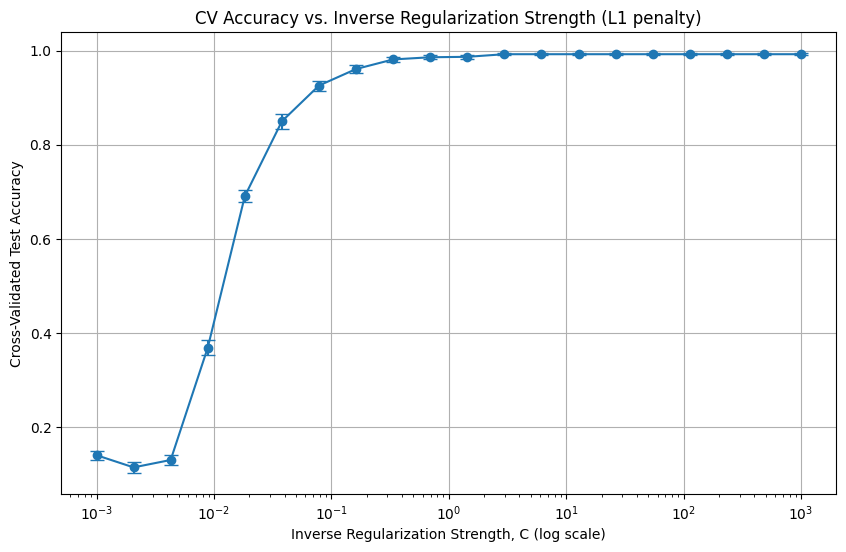

Best C: 2.9764
Best CV Accuracy with L1 penalty: 0.9926


In [51]:
# TODO
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

Cs = np.logspace(-3, 3, 20)

nfold = 10
kf = KFold(n_splits=nfold, shuffle=True, random_state=42)

cv_accuracy = []
cv_se = []

for C in Cs:
    fold_accuracies = []
    for train_index, test_index in kf.split(X_scaled):
        X_train = X_scaled.iloc[train_index]
        X_test  = X_scaled.iloc[test_index]
        y_train = y[train_index]
        y_test  = y[test_index]

        clf = LogisticRegression(
            penalty='l1',
            solver='saga',
            multi_class='multinomial',
            C=C,
            max_iter=2000,
            tol=1e-3
        )
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        fold_accuracies.append(np.mean(y_pred == y_test))

    mean_acc = np.mean(fold_accuracies)
    se_acc = np.std(fold_accuracies, ddof=1) / np.sqrt(nfold)
    cv_accuracy.append(mean_acc)
    cv_se.append(se_acc)

cv_accuracy = np.array(cv_accuracy)
cv_se = np.array(cv_se)

plt.figure(figsize=(10, 6))
plt.errorbar(Cs, cv_accuracy, yerr=cv_se, fmt='o-', capsize=5)
plt.xscale('log')
plt.xlabel("Inverse Regularization Strength, C (log scale)")
plt.ylabel("Cross-Validated Test Accuracy")
plt.title("CV Accuracy vs. Inverse Regularization Strength (L1 penalty)")
plt.grid(True)
plt.show()

best_index = np.argmax(cv_accuracy)
best_C = Cs[best_index]
best_accuracy = cv_accuracy[best_index]

print(f"Best C: {best_C:.4f}")
print(f"Best CV Accuracy with L1 penalty: {best_accuracy:.4f}")


In [52]:
def colab2pdf():
  # @title Download Notebook in PDF Format{display-mode:'form'}
  !apt-get install -yqq --no-install-recommends librsvg2-bin>/dev/null;
  import contextlib,datetime,google,io,IPython,ipywidgets,json,locale,nbformat,os,pathlib,requests,urllib,warnings,werkzeug,yaml,re;locale.setlocale(locale.LC_ALL,'en_US.UTF-8');warnings.filterwarnings('ignore',category=nbformat.validator.MissingIDFieldWarning);
  %matplotlib inline
  def convert(b):
    try:
      s.value='🔄 Converting';b.disabled=True
      n=pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f'http://{os.environ["COLAB_JUPYTER_IP"]}:{os.environ["KMP_TARGET_PORT"]}/api/sessions').json()[0]['name'])))
      p=pathlib.Path('/content/pdfs')/f'{datetime.datetime.utcnow().strftime("%Y%m%d_%H%M%S")}_{n.stem}';p.mkdir(parents=True,exist_ok=True);nb=nbformat.reads(json.dumps(google.colab._message.blocking_request('get_ipynb',timeout_sec=600)['ipynb']),as_version=4)
      u=[u for c in nb.cells if c.get('cell_type')=='markdown' for u in re.findall(r'!\[.*?\]\((https?://.*?)\)',c['source']) if requests.head(u,timeout=5).status_code!=200]
      if u:raise Exception(f"Bad Image URLs: {','.join(u)}")
      nb.cells=[cell for cell in nb.cells if '--Colab2PDF' not in cell.source]
      nb=nbformat.v4.new_notebook(cells=nb.cells or [nbformat.v4.new_code_cell('#')]);nbformat.validator.normalize(nb)
      nbformat.write(nb,(p/f'{n.stem}.ipynb').open('w',encoding='utf-8'))
      with (p/'config.yml').open('w', encoding='utf-8') as f: yaml.dump({'include-in-header':[{'text':r'\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}'}],'include-before-body':[{'text':r'\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}'}]},f)
      !quarto render {p}/{n.stem}.ipynb --metadata-file={p}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet
      google.colab.files.download(str(p/f'{n.stem}.pdf'));s.value=f'✅ Downloaded: {n.stem}.pdf'
    except Exception as e:s.value=f'❌ {str(e)}'
    finally:b.disabled=False
  if not pathlib.Path('/usr/local/bin/quarto').exists():
    !wget -q 'https://quarto.org/download/latest/quarto-linux-amd64.deb' && dpkg -i quarto-linux-amd64.deb>/dev/null && quarto install tinytex --update-path --quiet && rm quarto-linux-amd64.deb
  b=ipywidgets.widgets.Button(description='⬇️ Download');s=ipywidgets.widgets.Label();b.on_click(lambda b:convert(b));IPython.display.display(ipywidgets.widgets.HBox([b,s]))
colab2pdf() # | Colab2PDF v1.6 | https://github.com/drengskapur/colab2pdf | GPL-3.0-or-later |

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>